# <center>Organizaci&oacute;n de Datos</center>
## <center>Trabajo Práctico 1 : Reservas de Hotel</center>
## <center>Checkpoint 3</center>
### <center>Ensambles</center>

#### Integrantes grupo 19: Sudanalytics 
* Adrian Leandro Re
* Alan Toulouse
* Luciano Lorenzo
* Nicolas Tonizzo

# Imports y preparacion del dataset

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import make_scorer, f1_score, confusion_matrix, precision_score, recall_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

In [31]:
df = pd.read_csv("../dataset/hotels_train_procesado.csv")
df.columns

Index(['hotel', 'lead_time', 'arrival_date_year', 'arrival_date_month',
       'arrival_date_week_number', 'arrival_date_day_of_month',
       'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children',
       'babies', 'meal', 'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status_date', 'id', 'is_canceled', 'hotel_encoding',
       'tiene_hijos', 'es_extranjero', 'es_portugues', 'es_ingles',
       'es_frances', 'es_espanol', 'es_aleman', 'reserved_room_was_assigned',
       'required_a_car_parking_space', 'solo_desayuna_en_el_hotel',
       'pidio_todas_comidas', 'reservo_online', 'reservo_en_grupo',
       'reservo_sin_reembols

Declaramos el target y los features del dataframe que vamos a utilizar para predecir.

In [32]:
target = "is_canceled"

attrs = [
    "hotel_encoding",
    
    "lead_time",
    #"reservo_el_mismo_dia",
    "adr",

    #"stays_in_weekend_nights",
    "stays_in_week_nights",

    "tiene_hijos",
    "adults",
    # "children",
    # "babies",

    # Fechas
    "arrival_date_week_number",
    #"arrival_date_day_of_month",
    "arrival_date_year",

    "es_extranjero",
    #"es_portugues",
    #"es_ingles",
    #"es_frances",
    #"es_espanol",
    #"es_aleman",

    "reserved_room_was_assigned",

    "is_repeated_guest",
    "previous_cancellations", 
    #"previous_bookings_not_canceled",
    #"total_reservas_previas"
    "total_of_special_requests",
    "booking_changes",

    #'meal',
    "solo_desayuna_en_el_hotel",
    "pidio_todas_comidas",

    # 'required_car_parking_spaces',
    "required_a_car_parking_space",

    "reservo_sin_reembolso",
    "reservo_sin_depositar",
    "reservo_online",
    "reservo_en_grupo",
    "reservo_sin_compania",
    "reservo_sin_agente",
    "reservo_sin_paquete",
    
    # "days_in_waiting_list",
    "tuvo_dias_de_espera",
    
    "agent9",
    "agent240",
    "agent1",
    "agent14",
    "agent6",
]

**Dividimos el dataset en entrenamiento y validacion**, para poder validar que no estamos overfitteando al dataset de entrenamiento, y que el modelo predice bien a registros no vistos anteriormente. Vamos a utilizar mitad de el dataset para validacion y mitad del dataset para entrenamiento, ya que haciendo varias pruebas, SVC tarda muchisimo tiempo si el dataset es muy grande. De hecho para las pruebas usamos el split de entrenamiento todavia mas chico, para poder tener una idea general de cuales deberian ser los mejores parametros.

In [33]:
X = df[attrs].values
y = df[target].values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.5, shuffle=True)

Vamos a utilizar PCA para reducir las dimensiones en los datos, e intentar reducir los tiempos de entrenamiento, a su vez que reducimos el overfitting. Nos viene bien porque ambos (PCA Y SVM) necesitan que los datos esten centrados, en este caso utilizamos el standard scaler. Graficamos la varianza explicada en funcion del numero de componentes para tener una idea del numero de componentes a utilizar:

Text(0, 0.5, 'Varianza Explicada (%)')

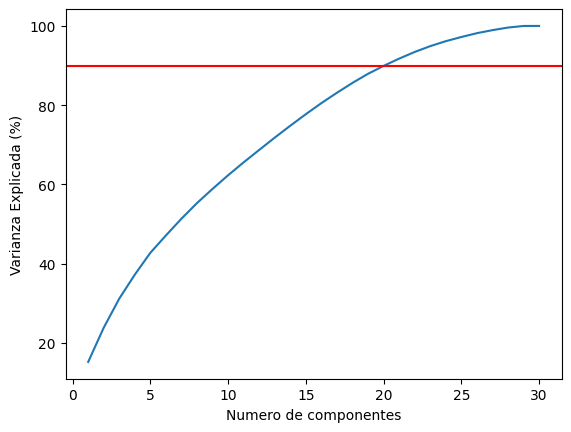

In [60]:
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)

pca = PCA(n_components = None)
pca.fit(X_train_scaled)

#Cantidad de Componentes
componentes = len(pca.explained_variance_ratio_) 

#Grafico la Varianza Explicada 
plt.plot(range(1,componentes+1), np.cumsum(pca.explained_variance_ratio_ * 100))
plt.axhline(90, c= 'red')
plt.xlabel("Numero de componentes")
plt.ylabel("Varianza Explicada (%)")

Observando el plot concluimos que un buen numero de componentes, que por lo menos el 0.9 de varianza explicada, tiene que mayor que 21.

Creamos el pipeline, el cual comienza por estandarizar el dataset, ya que ambos PCA y SVM lo necesitan:

In [58]:
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA()),
    ("svm", SVC(kernel='rbf')),
])

Luego de un par de pruebas individuales con el pipe, concluimos que un buen rango para poner los valores de los hiperparametros a ser optimizados por cross validation es el siguiente:

In [45]:
params_grid = {
    "pca__n_components": list(range(21, 30)),
    "svm__C": list(range(10, 30)), 
    "svm__gamma": np.linspace(0.001, 0.1, 30),
}

Utilizamos cross validation randomizado para encontrar los mejores hiperparametros:

In [47]:
kfoldcv = StratifiedKFold(n_splits=4)

model = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=params_grid,
    scoring=make_scorer(f1_score),
    cv=kfoldcv,
    n_iter=10,
    n_jobs=-1,
)

In [48]:
model.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=4, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('pca', PCA(n_components=25)),
                                             ('svm', SVC())]),
                   n_jobs=-1,
                   param_distributions={'pca__n_components': [24, 25, 26, 27,
                                                              28, 29],
                                        'svm__C': [10, 11, 12, 13, 14, 15, 16,
                                                   17, 18, 19, 20, 21, 22, 23,
                                                   24, 25, 26, 27, 28, 29],
                                        'svm__gamma': array([0.001     , 0.00441379, 0.00782759, 0.01124138, 0.01465517,
       0.01806897, 0.02148276, 0.02489655, 0.02831034, 0.03172414,
       0.03513793, 0.03855172, 0.04196552, 0.04537931, 0.0487931 ,
       0.0522069 , 0.05562069, 0.05903448, 0.06244828, 0.06586207,
       0.06927586, 0.07268966, 0.07610345, 0.07951724, 0.08293103,
       0.08634483, 0.08975862, 0.09317241, 0.09658621, 0.1       ])},
                   scoring=make_scorer(f1_score))

Despues de un largo rato esperando, su mejor resultado fue:

In [51]:
model.best_score_

0.8558887156969717

Mejores parametros

In [49]:
model.best_params_

{'svm__gamma': 0.03513793103448276, 'svm__C': 14, 'pca__n_components': 27}

Score en validacion y training:

In [52]:
model.score(X_val, y_val)

0.85826224328594

In [53]:
model.score(X_train, y_train)

0.8871647509578544

Podemos visualizar las estadisticas completas del cross validation:

In [50]:
pd.DataFrame(model.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_svm__gamma,param_svm__C,param_pca__n_components,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,82.641978,9.148221,6.535182,0.622050,0.048793,20,28,"{'svm__gamma': 0.048793103448275865, 'svm__C':...",0.852617,0.848857,0.850531,0.852657,0.851165,0.001586,9
1,77.042934,8.115562,5.588649,0.682861,0.059034,22,24,"{'svm__gamma': 0.05903448275862069, 'svm__C': ...",0.852815,0.850237,0.848392,0.853439,0.851221,0.002027,8
2,75.105515,9.114206,5.858645,0.477397,0.048793,18,26,"{'svm__gamma': 0.048793103448275865, 'svm__C':...",0.854861,0.850645,0.849795,0.854712,0.852503,0.002303,6
3,36.635513,1.689601,6.217127,0.265260,0.007828,15,25,"{'svm__gamma': 0.007827586206896553, 'svm__C':...",0.845632,0.843622,0.846193,0.847510,0.845739,0.001399,10
4,77.691939,7.643468,6.255165,0.740957,0.055621,12,29,"{'svm__gamma': 0.05562068965517242, 'svm__C': ...",0.852650,0.850122,0.850672,0.853529,0.851743,0.001396,7
5,42.146220,0.840442,6.122818,0.808415,0.038552,11,25,"{'svm__gamma': 0.03855172413793104, 'svm__C': ...",0.855155,0.852634,0.854042,0.858534,0.855091,0.002179,3
6,59.649413,1.083857,6.988599,0.922451,0.031724,21,27,"{'svm__gamma': 0.031724137931034485, 'svm__C':...",0.855873,0.852446,0.855753,0.857657,0.855432,0.001882,2
7,47.892825,1.576234,6.246672,1.283116,0.018069,22,25,"{'svm__gamma': 0.01806896551724138, 'svm__C': ...",0.852509,0.850809,0.853245,0.855829,0.853098,0.001808,5
8,80.556033,3.809442,5.540770,0.435663,0.038552,27,27,"{'svm__gamma': 0.03855172413793104, 'svm__C': ...",0.854532,0.850944,0.853708,0.854789,0.853493,0.001525,4
9,51.694997,0.499005,4.513875,0.707819,0.035138,14,27,"{'svm__gamma': 0.03513793103448276, 'svm__C': ...",0.855657,0.853792,0.855972,0.858133,0.855889,0.001541,1


Ploteamos las matrices de confusion, ambas para el conjunto de entrenamiento como el de validacion:

precision 0.874213440724893
recall 0.9005055742805289


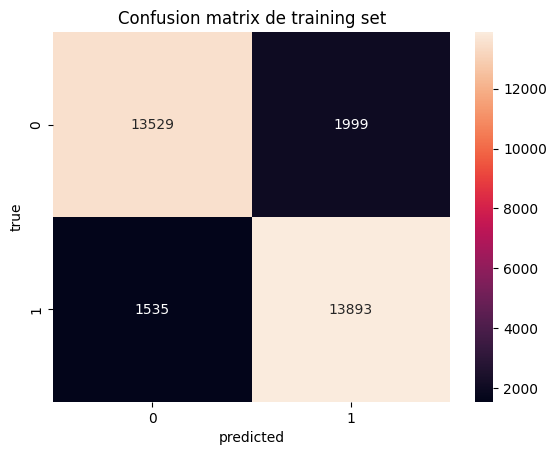

In [54]:
y_pred = model.predict(X_train)
confusion = confusion_matrix(y_train, y_pred)
sns.heatmap(confusion, annot=True, fmt='.0f')
plt.ylabel('true')
plt.xlabel('predicted')
plt.title("Confusion matrix de training set")
print("precision", precision_score(y_train, y_pred))
print("recall", recall_score(y_train, y_pred))

precision 0.8416682159013448
recall 0.8755237542706118


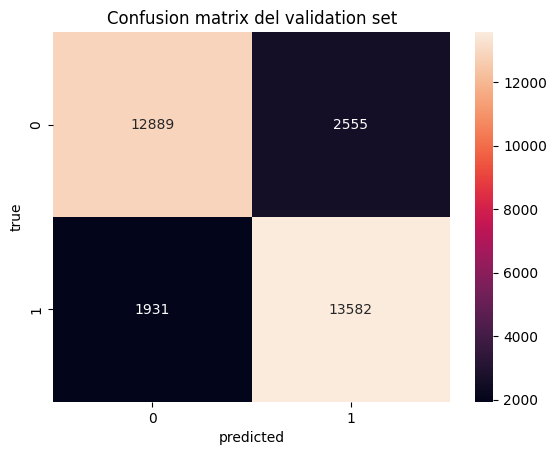

In [57]:
y_pred = model.predict(X_val)
confusion = confusion_matrix(y_val, y_pred)
sns.heatmap(confusion, annot=True, fmt='.0f')
plt.ylabel('true')
plt.xlabel('predicted')
plt.title("Confusion matrix del validation set")
print("precision", precision_score(y_val, y_pred))
print("recall", recall_score(y_val, y_pred))

# Creacion de submit

In [61]:
def create_submission(model): 
    df_test = pd.read_csv("../dataset/hotels_test_procesado.csv")
    assert(len(df_test)==26535)

    prediccion = model.predict(df_test[attrs].values)
    assert(len(prediccion)==26535)

    submit = pd.DataFrame(
        {"is_canceled": prediccion},
        index=df_test["id"],
    )
    assert(len(submit)==26535)

    submit.to_csv("../dataset/submit.csv")

In [62]:
create_submission(model)

# Guardando el modelo con pickle

Guardamos la svm con pickle:

In [63]:
import pickle

with open('../modelos/svm.pickle', 'wb') as file:
    pickle.dump(model, file)